In [17]:
import torch
import torch.nn as nn
import torch.functional as F
from utils import *

# Neural Networks
class SequenceModel(nn.Module):
    def __init__(self, representationSize, actionSize, recurrentStateSize):
        super().__init__()
        self.recurrent = nn.GRUCell(representationSize + actionSize, recurrentStateSize)

    def forward(self, representation, action, recurrentState):
        recurrentState = self.recurrent(torch.cat((representation, action), -1), recurrentState)
        return recurrentState

class PriorNet(nn.Module):
    def __init__(self, inputSize, representationClasses=16):
        super().__init__()
        self.representationSize = representationClasses
        self.mlp = sequentialModel1D(inputSize, [256, 256], representationClasses**2)
    
    def forward(self, x):
        x = self.mlp(x)
        x = x.view(-1, self.representationSize, self.representationSize)
        _, indices = torch.max(x, dim=-1)
        representation = F.one_hot(indices, num_classes=self.representationSize)
        return representation
    
class PosteriorNet(nn.Module):
    def __init__(self, inputSize, representationClasses=16):
        super().__init__()
        self.representationSize = representationClasses
        self.mlp = sequentialModel1D(inputSize, [256, 256], representationClasses**2)
    
    def forward(self, x):
        x = self.mlp(x)
        x = x.view(-1, self.representationSize, self.representationSize)
        _, indices = torch.max(x, dim=-1)
        representation = F.one_hot(indices, num_classes=self.representationSize)
        return representation

class ConvEncoder(nn.Module):
    def __init__(self, inputShape, outputSize):
        super(ConvEncoder, self).__init__()
        c, h, w = inputShape
        self.convolutionalNet = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, h/2, w/2)
            nn.Tanh(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, h/4, w/4)
            nn.Tanh(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, h/8, w/8)
            nn.Tanh(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, h/16, w/16)
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(256 * (h // 16) * (w // 16), outputSize),
            nn.Tanh(),
        )

    def forward(self, obs):
        return self.convolutionalNet(obs/255.0)

class ConvDecoder(nn.Module):
    def __init__(self, inputSize, outputShape):
        super(ConvDecoder, self).__init__()
        self.outputShape = outputShape
        c, h, w = outputShape
        self.fc = nn.Sequential(
            nn.Linear(inputSize, 256 * (h // 16) * (w // 16)),
            nn.Tanh(),
        )
        self.deconvolutionalNet = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, h/8, w/8)
            nn.Tanh(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, h/4, w/4)
            nn.Tanh(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, h/2, w/2)
            nn.Tanh(),
            nn.ConvTranspose2d(32, c, kernel_size=4, stride=2, padding=1),  # Output: (c, h, w)
            nn.Sigmoid(),  # Output pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.fc(x)
        batch_size = x.size(0)
        c, h, w = 256, self.obs_shape[1] // 16, self.obs_shape[2] // 16
        x = x.view(batch_size, c, h, w)
        return self.deconvolutionalNet(x)


In [18]:
import torch
import torch.nn as nn
import torch.functional as F
from utils import *
import pickle

with open('episode_0_data.pkl', 'rb') as f:
    data = pickle.load(f)
observations = data['observations']
actions = data['actions']

representationClasses = 16
representationSize = representationClasses ** 2
actionSize = 3
recurrentStateSize = 256
compressedObservationsSize = 256
obsShape = (3, 84, 96)

convEncoder     = ConvEncoder(obsShape, compressedObservationsSize)
convDecoder     = ConvDecoder(representationSize + recurrentStateSize, obsShape)
sequenceModel   = SequenceModel(representationSize, actionSize, recurrentStateSize)
priorNet        = PriorNet(recurrentStateSize, representationClasses)
posteriorNet    = PosteriorNet(recurrentStateSize + compressedObservationsSize, representationClasses)

In [19]:
encodedObservations = convEncoder(observations)

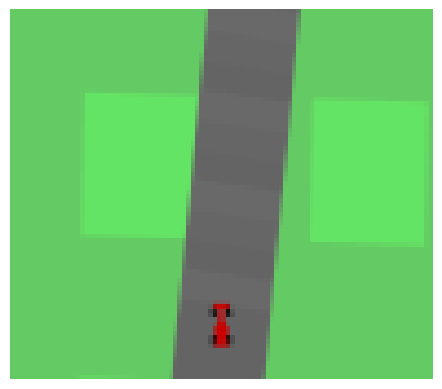

In [20]:
displayImage(np.transpose(observations[50], (1, 2, 0)))